In [9]:
# -------------------------------------------------------------
# Sección 1: Configuración inicial
# -------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import torch
import random

from darts import TimeSeries
from darts.models import RNNModel
from darts.utils.model_selection import train_test_split
import optuna
from sklearn.preprocessing import StandardScaler

# Fijar semillas para reproducibilidad
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


In [10]:
# -------------------------------------------------------------
# Sección 2: Carga de datos
# -------------------------------------------------------------
df_train = pd.read_parquet('../../Datos/df_train.parquet')
df_test  = pd.read_parquet('../../Datos/df_test.parquet')

print("Entrenamiento:", df_train.shape)
print(df_train.head(), "\n")
print("Test (sin target):", df_test.shape)
print(df_test.head())


Entrenamiento: (3680, 20)
          id  id_bar  anio  semana  ESTRATO  area_barrio  dengue  \
0  4_2015_01       4  2015       1      3.0        0.560     0.0   
1  5_2015_01       5  2015       1      3.0        0.842     0.0   
2  3_2015_01       3  2015       1      1.0        0.781     0.0   
3  8_2015_01       8  2015       1      2.0        0.394     0.0   
4  9_2015_01       9  2015       1      2.0        0.292     0.0   

   concentraciones  vivienda  equipesado  sumideros  maquina  lluvia_mean  \
0              0.0       0.0         0.0        0.0      0.0     0.000651   
1              0.0       0.0         0.0        0.0      0.0     0.000651   
2              0.0       0.0         0.0        0.0      0.0     0.000651   
3              0.0       0.0         0.0        0.0      0.0     0.000651   
4              0.0       0.0         0.0        0.0      0.0     0.000651   

   lluvia_var  lluvia_max  lluvia_min  temperatura_mean  temperatura_var  \
0    0.000041      0.0625 

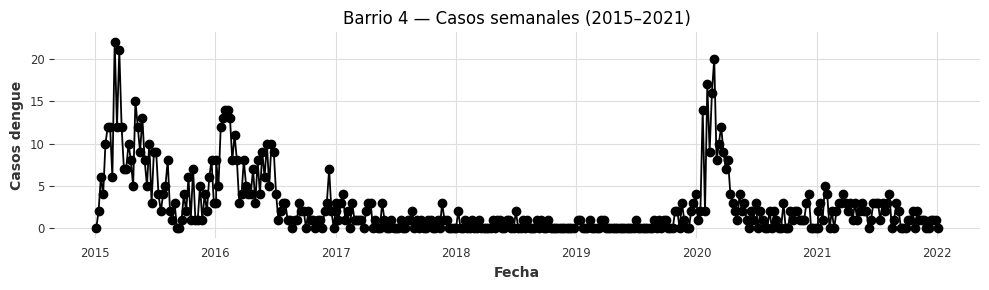

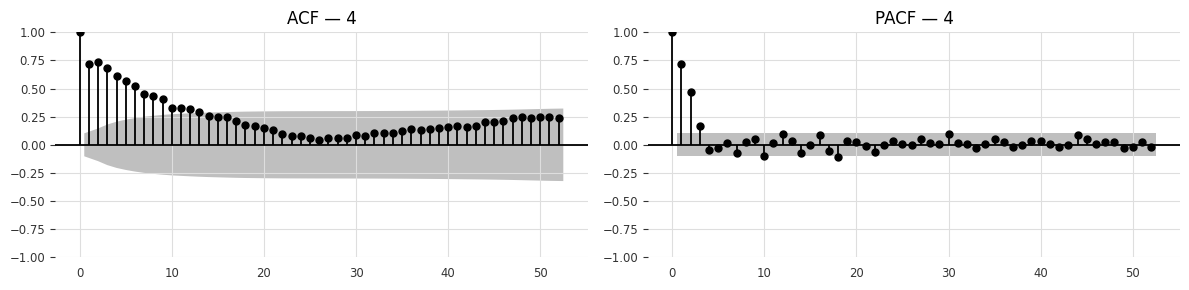

Sugerencia input_chunk_length para 4: 20–30 semanas



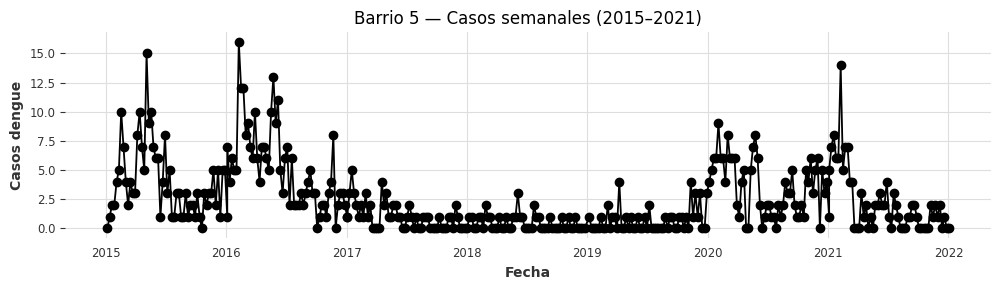

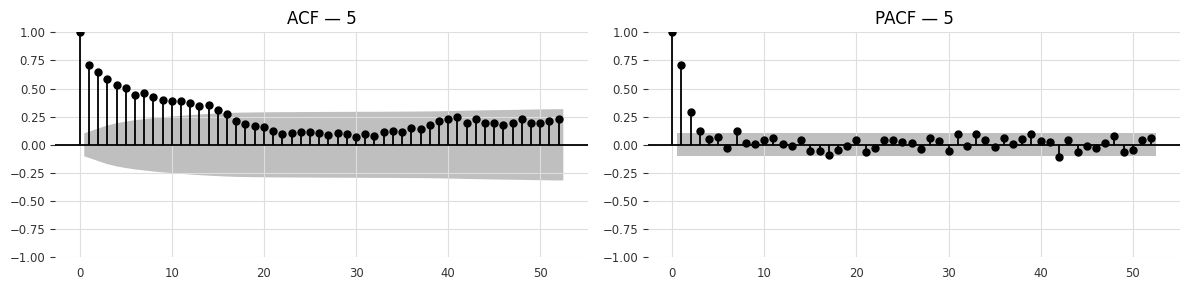

Sugerencia input_chunk_length para 5: 20–30 semanas



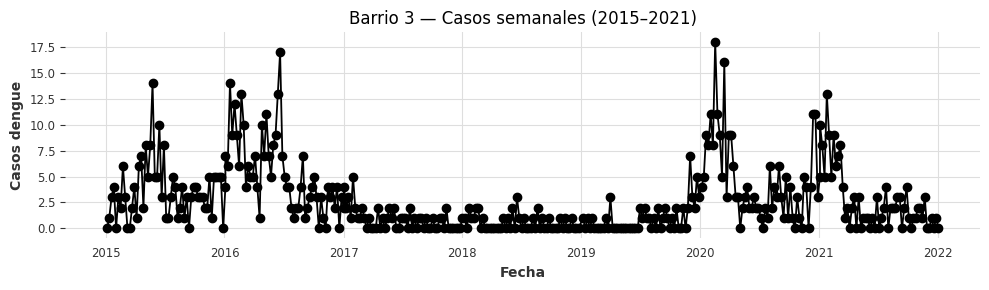

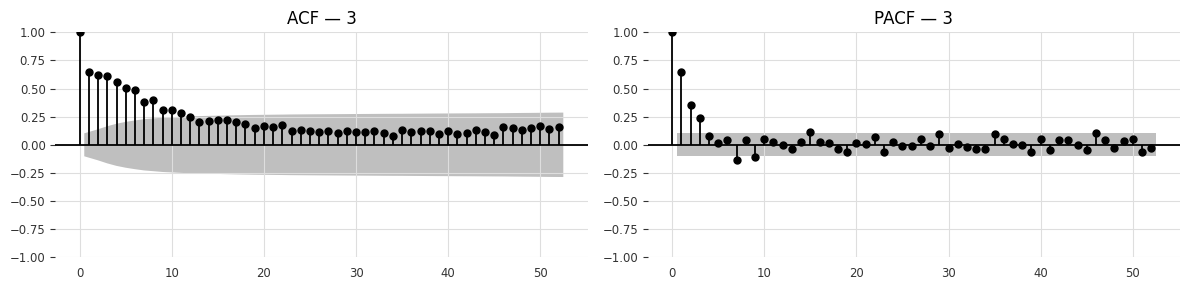

Sugerencia input_chunk_length para 3: 20–30 semanas



In [11]:
# -------------------------------------------------------------
# Sección 3: Análisis exploratorio de series de tiempo
# -------------------------------------------------------------
def week_to_date(row):
    return pd.to_datetime(f"{int(row.anio)}-{int(row.semana)}-1", format="%Y-%W-%w")

df_train['date'] = df_train.apply(week_to_date, axis=1)

for id_bar in df_train['id_bar'].unique()[:3]:
    sub = df_train[df_train['id_bar'] == id_bar].sort_values('date')
    plt.figure(figsize=(10, 3))
    plt.plot(sub['date'], sub['dengue'], marker='o')
    plt.title(f"Barrio {id_bar} — Casos semanales (2015–2021)")
    plt.xlabel("Fecha"); plt.ylabel("Casos dengue")
    plt.tight_layout(); plt.show()

    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    plot_acf(sub['dengue'], lags=52, ax=axes[0])
    plot_pacf(sub['dengue'], lags=52, ax=axes[1])
    axes[0].set_title(f"ACF — {id_bar}")
    axes[1].set_title(f"PACF — {id_bar}")
    plt.tight_layout(); plt.show()

    print(f"Sugerencia input_chunk_length para {id_bar}: 20–30 semanas\n")


In [12]:
# -------------------------------------------------------------
# Sección 4: Preprocesamiento
# -------------------------------------------------------------
df_test['date'] = df_test.apply(week_to_date, axis=1)

series_dict = {}
for id_bar in df_train['id_bar'].unique():
    sub = df_train[df_train['id_bar'] == id_bar].copy()
    sub = sub.sort_values('date')
    sub_agg = (
        sub
        .groupby('date')
        .agg({'dengue':'sum','ESTRATO':'first','area_barrio':'first'})
        .reset_index()
    )

    scaler_cov    = StandardScaler()
    cov_scaled    = scaler_cov.fit_transform(sub_agg[['ESTRATO','area_barrio']])
    cov_df        = pd.DataFrame(cov_scaled,
                                 index=sub_agg['date'],
                                 columns=['ESTRATO','area_barrio'])

    scaler_target = StandardScaler()
    tgt_scaled    = scaler_target.fit_transform(sub_agg[['dengue']])
    tgt_df        = pd.DataFrame(tgt_scaled,
                                 index=sub_agg['date'],
                                 columns=['dengue'])

    ts_target = TimeSeries.from_series(
        tgt_df['dengue'],
        fill_missing_dates=True,
        freq='W-MON'
    )
    ts_covariates = TimeSeries.from_dataframe(
        cov_df,
        fill_missing_dates=True,
        freq='W-MON'
    )

    series_dict[id_bar] = {
        'target': ts_target,
        'covariates': ts_covariates,
        'scaler_target': scaler_target,
        'scaler_cov': scaler_cov
    }

print(f"Preparadas series de {len(series_dict)} barrios.")


Preparadas series de 10 barrios.


In [13]:
# -------------------------------------------------------------
# Sección 5: Definición del modelo GRU en DARTS
# -------------------------------------------------------------
def create_gru_model(input_chunk_length, hidden_dim, num_layers,
                     dropout, lr, batch_size):
    return RNNModel(
        model='GRU',
        input_chunk_length=input_chunk_length,
        output_chunk_length=1,
        hidden_dim=hidden_dim,
        n_rnn_layers=num_layers,
        dropout=dropout,
        batch_size=batch_size,
        optimizer_kwargs={'lr': lr},
        random_state=SEED,
        training_length=input_chunk_length
    )


In [14]:
# -------------------------------------------------------------
# Sección 6: Optimización con Optuna
# -------------------------------------------------------------
import numpy as np

def objective(trial):
    # Rangos más conservadores para garantizar completitud
    input_len   = trial.suggest_int('input_chunk_length', 12, 30)
    hidden_dim  = trial.suggest_int('hidden_dim', 16, 64, step=16)
    n_layers    = trial.suggest_int('num_layers', 1, 2)
    dropout     = 0.0 if n_layers == 1 else trial.suggest_float('dropout', 0.1, 0.3)
    lr          = trial.suggest_float('lr', 1e-3, 1e-2, log=True)
    batch_size  = trial.suggest_categorical('batch_size', [16, 32])

    # Serie de validación
    id_bar = list(series_dict.keys())[0]
    ts     = series_dict[id_bar]['target']

    # Split temporal
    train_ts, val_ts = train_test_split(ts, test_size=52, axis=0)

    # Crear modelo
    model = create_gru_model(input_len, hidden_dim, n_layers,
                             dropout, lr, batch_size)

    # Entrenar y predecir dentro de try/except
    try:
        model.fit(series=train_ts, verbose=False, epochs=5)
        pred = model.predict(n=52)
        mse  = ((val_ts.values() - pred.values())**2).mean()
        # Si nan, asignar gran valor
        return float(mse) if not np.isnan(mse) else 1e6
    except Exception:
        # En caso de error, devolver penalización alta
        return 1e6

# Ejecutar optimización
study = optuna.create_study(direction='minimize', study_name='gru_dengue')
study.optimize(objective, n_trials=20, show_progress_bar=True)

# Reporte de resultados
print("Número de trials completos:", len(study.trials))
print("Mejor MSE:", study.best_trial.value)
print("Mejores parámetros:", study.best_trial.params)


[I 2025-06-15 11:59:26,843] A new study created in memory with name: gru_dengue


  0%|          | 0/20 [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:27,728] Trial 0 finished with value: 1000000.0 and parameters: {'input_chunk_length': 23, 'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.11640333781466004, 'lr': 0.005279795278644277, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:28,054] Trial 1 finished with value: 1000000.0 and parameters: {'input_chunk_length': 30, 'hidden_dim': 48, 'num_layers': 1, 'lr': 0.0032925139062519792, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:28,547] Trial 2 finished with value: 1000000.0 and parameters: {'input_chunk_length': 23, 'hidden_dim': 16, 'num_layers': 2, 'dropout': 0.292402392484571, 'lr': 0.007408771772342039, 'batch_size': 16}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:28,880] Trial 3 finished with value: 1000000.0 and parameters: {'input_chunk_length': 19, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.190043453551048, 'lr': 0.006241257245386415, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:29,125] Trial 4 finished with value: 1000000.0 and parameters: {'input_chunk_length': 22, 'hidden_dim': 48, 'num_layers': 1, 'lr': 0.0023401524016992783, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:29,503] Trial 5 finished with value: 1000000.0 and parameters: {'input_chunk_length': 19, 'hidden_dim': 48, 'num_layers': 1, 'lr': 0.0022638485986489505, 'batch_size': 16}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:29,853] Trial 6 finished with value: 1000000.0 and parameters: {'input_chunk_length': 27, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.18808137628102822, 'lr': 0.006213303788050727, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:30,127] Trial 7 finished with value: 1000000.0 and parameters: {'input_chunk_length': 13, 'hidden_dim': 48, 'num_layers': 2, 'dropout': 0.20754871646753298, 'lr': 0.0018533891915353603, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:30,677] Trial 8 finished with value: 1000000.0 and parameters: {'input_chunk_length': 23, 'hidden_dim': 64, 'num_layers': 2, 'dropout': 0.18047537258555135, 'lr': 0.0010764470115892052, 'batch_size': 16}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:30,950] Trial 9 finished with value: 1000000.0 and parameters: {'input_chunk_length': 18, 'hidden_dim': 16, 'num_layers': 2, 'dropout': 0.20397689837114458, 'lr': 0.00936623577327571, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:31,305] Trial 10 finished with value: 1000000.0 and parameters: {'input_chunk_length': 13, 'hidden_dim': 32, 'num_layers': 1, 'lr': 0.0042716597032938265, 'batch_size': 16}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:31,547] Trial 11 finished with value: 1000000.0 and parameters: {'input_chunk_length': 30, 'hidden_dim': 32, 'num_layers': 1, 'lr': 0.0040809156395486285, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:31,799] Trial 12 finished with value: 1000000.0 and parameters: {'input_chunk_length': 27, 'hidden_dim': 32, 'num_layers': 1, 'lr': 0.0035927523364431006, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:32,048] Trial 13 finished with value: 1000000.0 and parameters: {'input_chunk_length': 29, 'hidden_dim': 32, 'num_layers': 1, 'lr': 0.004817740082738787, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:32,358] Trial 14 finished with value: 1000000.0 and parameters: {'input_chunk_length': 26, 'hidden_dim': 48, 'num_layers': 2, 'dropout': 0.11144820927342511, 'lr': 0.0027847067133032295, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=5` reached.


[I 2025-06-15 11:59:32,607] Trial 15 finished with value: 1000000.0 and parameters: {'input_chunk_length': 25, 'hidden_dim': 16, 'num_layers': 1, 'lr': 0.00551709377072773, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:32,844] Trial 16 finished with value: 1000000.0 and parameters: {'input_chunk_length': 16, 'hidden_dim': 32, 'num_layers': 1, 'lr': 0.0013889787594447856, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:33,172] Trial 17 finished with value: 1000000.0 and parameters: {'input_chunk_length': 29, 'hidden_dim': 48, 'num_layers': 2, 'dropout': 0.11329979852208837, 'lr': 0.0029501464602554052, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[I 2025-06-15 11:59:33,579] Trial 18 finished with value: 1000000.0 and parameters: {'input_chunk_length': 25, 'hidden_dim': 48, 'num_layers': 1, 'lr': 0.0075577771559200094, 'batch_size': 16}. Best is trial 0 with value: 1000000.0.


`Trainer.fit` stopped: `max_epochs=5` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

[I 2025-06-15 11:59:33,862] Trial 19 finished with value: 1000000.0 and parameters: {'input_chunk_length': 16, 'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.1373901770822782, 'lr': 0.0033248408728795147, 'batch_size': 32}. Best is trial 0 with value: 1000000.0.
Número de trials completos: 20
Mejor MSE: 1000000.0
Mejores parámetros: {'input_chunk_length': 23, 'hidden_dim': 32, 'num_layers': 2, 'dropout': 0.11640333781466004, 'lr': 0.005279795278644277, 'batch_size': 32}
